In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset

import numpy as np

import math

import time

import dataloader
import models
import training_fun

import optuna

import joblib

import pygad

import HydroErr

from matplotlib import pyplot as plt


In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

SEQ_LENGTH = 365 * 2
TARGET_SEQ_LENGTH = 365
BASE_LENGTH = SEQ_LENGTH - TARGET_SEQ_LENGTH

FORCING_DIM = 3

N_CATCHMENTS = 3007

# training hyperparameters
EPOCHS = 500
TRAIN_YEAR = 19
PATIENCE = 20

use_amp = True
compile_model = False

if compile_model:
    torch.set_float32_matmul_precision("high")

memory_saving = False
if memory_saving:
    storge_device = "cpu"
    computing_device = DEVICE
    VAL_STEPS = 500
else:
    storge_device = DEVICE
    computing_device = DEVICE

In [3]:
dall = dataloader.Forcing_Data(
    "data/camels_all.csv",
    record_length=7670,
    storge_device=storge_device,
    seq_length=SEQ_LENGTH,
    target_seq_length=TARGET_SEQ_LENGTH,
    base_length=BASE_LENGTH,
)

x_all, y_all = dall.get_val_batch()

In [31]:
decoder = torch.load("data/final_lstm_decoder2.pt", map_location=torch.device('cpu')).to(computing_device)
decoder.eval()

camels_embeddings = np.loadtxt("data/ga_camels_embeddings2.csv", delimiter=",")

In [6]:
def pred_hydrograh(x, embedding):
    
    embedding = torch.from_numpy(embedding).unsqueeze(0).to(dtype=torch.float32).to(computing_device)
    embedding = embedding.expand(x.shape[0], -1)
    
    pred = decoder.decode(embedding, x).view(-1).detach().cpu().numpy()
    
    return pred

In [50]:
selected_catchment = 0

x = x_all[:,selected_catchment,:,:].to(computing_device)
y = y_all[:,selected_catchment,:].to(computing_device)

embedding = camels_embeddings[selected_catchment,:].copy()

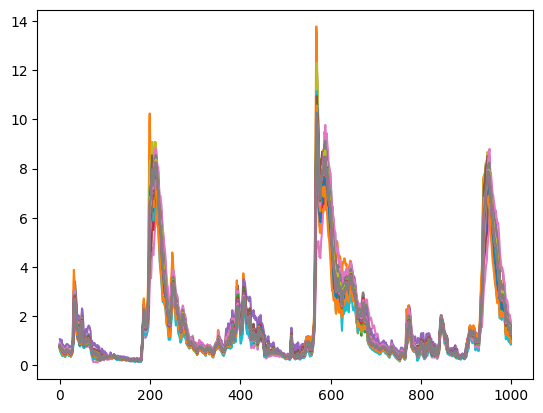

In [47]:
selected_dims = [0, 1, 2, 3, 4, 5, 6, 7]
variations = [-0.5, -0.25, -0.1, 0.1, 0.25, 0.5]

for selected_dim in selected_dims:

    for variation in variations:
        embedding2 = embedding.copy()
        
        embedding2[selected_dim] = embedding[selected_dim] + np.abs(embedding[selected_dim])*(variation)
        pred = pred_hydrograh(x, embedding2)
        
        file_name = f"data/hydrograph/dim_{selected_dim}_var_{variation}.csv"
        
        np.savetxt(file_name, pred, delimiter=",")
        
        plt.plot(pred[1000:2000])
        
plt.show()

# write the original prediction
pred = pred_hydrograh(x, embedding)
np.savetxt("data/hydrograph/original.csv", pred, delimiter=",")

In [ ]:
pred = pred_hydrograh(x, embedding)

plt.plot(pred)

In [52]:
y[0,:]

tensor([0.4672, 0.4618, 0.4563, 0.4455, 0.4400, 0.4346, 0.4183, 0.4074, 0.3966,
        0.3803, 0.3748, 0.3857, 0.3911, 0.3803, 0.3857, 0.4020, 0.3857, 0.3966,
        0.4129, 0.4292, 0.4455, 0.4509, 0.4455, 0.4292, 0.4129, 0.4563, 0.5215,
        0.5215, 0.5161, 0.5107, 0.4944, 0.4835, 0.4726, 0.4618, 0.4509, 0.4400,
        0.4183, 0.4074, 0.3966, 0.4020, 0.4400, 0.4672, 0.4563, 0.4400, 0.4237,
        0.4129, 0.4074, 0.4020, 0.3966, 0.3911, 0.3857, 0.3803, 0.3857, 0.4292,
        0.4400, 0.4237, 0.4183, 0.4129, 0.4020, 0.3966, 0.3911, 0.3748, 0.3694,
        0.3640, 0.3585, 0.3531, 0.3477, 0.3477, 0.3531, 0.4020, 0.4563, 0.5259,
        0.6519, 0.8149, 0.9550, 1.1191, 1.3038, 1.5211, 1.7384, 1.9557, 2.2274,
        2.4990, 2.6837, 2.5968, 1.9992, 1.6406, 1.4777, 1.3147, 1.1843, 1.1626,
        1.1626, 1.1734, 1.1734, 1.3690, 1.8688, 2.1404, 2.3903, 2.5968, 2.7815,
        2.9553, 3.0966, 3.1618, 3.1509, 3.1183, 3.1292, 3.2052, 3.3791, 3.4551,
        3.5094, 3.6942, 4.2265, 4.7589, 

In [ ]:
selected_catchment = 0

x = x_batch_train_val[:,selected_catchment,:,:].to(computing_device)
y = y_batch_train_val[:,selected_catchment,:].to(computing_device)

embedding = camels_embeddings[selected_catchment,:]*1.1

solution = torch.from_numpy(solution).unsqueeze(0).to(dtype=torch.float32).to(computing_device)
solution = solution.expand(x.shape[0], -1)

pred = decoder.decode(solution, x).view(-1).detach().cpu().numpy()

In [40]:
x = x_batch_train_val[:,selected_catchment,:,:].to(computing_device)
y = y_batch_train_val[:,selected_catchment,:].to(computing_device)

embedding = camels_embeddings[selected_catchment,:]*1.1

pred = pred_hydrograh(x, embedding)

plt.plot(pred)


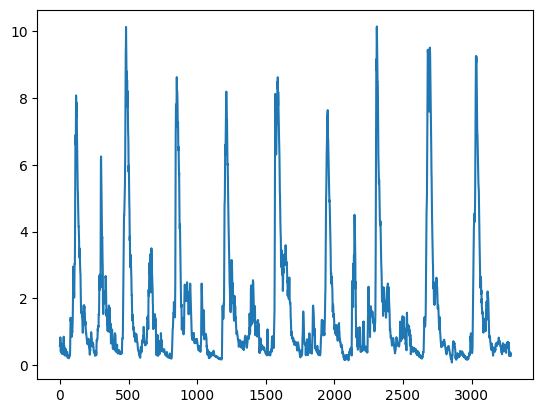

In [45]:
from matplotlib import pyplot as plt

plt.plot(pred)

In [32]:
selected_catchment = 0

x_train_val = x_batch_train_val[:,selected_catchment,:,:].to(computing_device)
y_train_val = y_batch_train_val[:,selected_catchment,:].to(computing_device)

x = x_train_val
y = y_train_val

embedding = camels_embeddings[0,:]*1.1

embedding = torch.from_numpy(embedding).unsqueeze(0).to(dtype=torch.float32).to(computing_device)
embedding = embedding.expand(x.shape[0], -1)

pred = decoder.decode(embedding, x).view(-1).detach().cpu().numpy()


In [33]:
pred

array([0.5765509 , 0.59495205, 0.7476128 , ...,        nan,        nan,
              nan], dtype=float32)

In [34]:
str(pred)

'[0.5765509  0.59495205 0.7476128  ...        nan        nan        nan]'

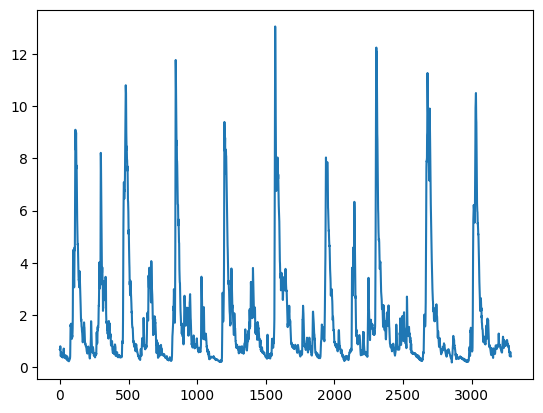

In [31]:
from matplotlib import pyplot as plt

plt.plot(pred)


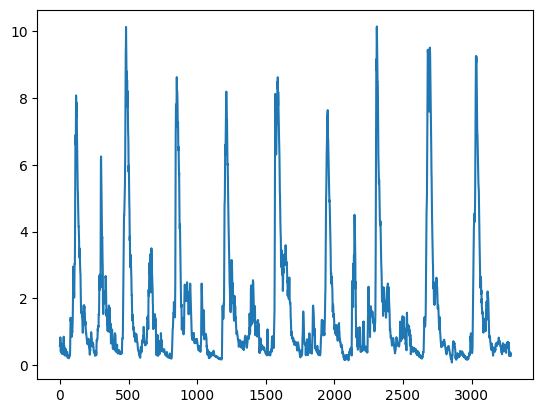

In [35]:
from matplotlib import pyplot as plt

plt.plot(pred)